In [20]:
!pip install xgboost

     |████████████████████████████████| 1.8 MB 4.1 MB/s eta 0:00:01


In [29]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm 
from scipy import stats
import itertools
from iminuit import Minuit   
from scipy.optimize import minimize
import sys  
from importlib import reload
from scipy import interpolate
import copy
import pandas as pd
import math

# Standard libraires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import ultranest
from ultranest.plot import cornerplot
from ultranest.plot import PredictionBand


# external libraries
sys.path.append('../') 
import AdvAppStatFunctions as aas

# setting for plotting
from matplotlib.patches import ConnectionPatch
import seaborn as sns
import matplotlib.patches as patches
plt.style.use('seaborn-white')
sns.set_style('white', {'legend.frameon':True})
plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 14
sns.set_palette("colorblind")
color = sns.color_palette("colorblind")

from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, log_loss, precision_score
from sklearn.metrics import roc_curve, auc

In [24]:
import warnings
warnings.filterwarnings('ignore')

# Problem 4

## Parsing data and setting label

In [2]:
train = pd.read_csv('Data/Exam_2022_Prob4_TrainData.csv', header=0, delimiter=',').iloc[:,1:-1]
train_class = pd.read_csv('Data/Exam_2022_Prob4_TrainData.csv', header=0, delimiter=',').iloc[:,-1]

test = pd.read_csv('Data/Exam_2022_Prob4_TestData.csv', header=0, delimiter=',').iloc[:,1:-1]
test_class = pd.read_csv('Data/Exam_2022_Prob4_TestData.csv', header=0, delimiter=',').iloc[:,-1]

label = 'No show'
features = train.keys()

### Exploring training and testing data

In [3]:
aas.explore_data(train, train_class, test, test_class, label)

Training data 
Total = 20000 
No show == 1: 4049 
No show == 0: 15951 
SN-ratio = 0.254

Testing data 
Total = 20000 
No show == 1: 4013 
No show == 0: 15987 
SN-ratio = 0.251


/var/folders/5c/kvpjh5n11_j2mp3l99c22xdr0000gn/T/ipykernel_21054/433369910.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


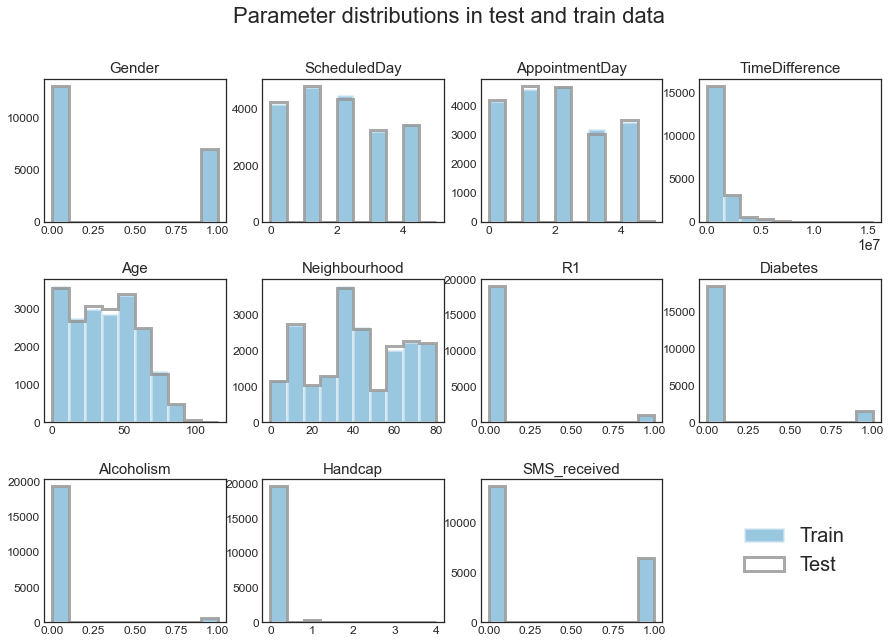

In [4]:
# Show 1D distributions
fig, ax = plt.subplots(nrows=3, ncols=4, gridspec_kw={'wspace':0.2, 'hspace':0.4}, figsize=(15,10))
fig.delaxes(ax[2,3])
ax = ax.flatten()

# Loop over features
for i in range(len(features)):
    ax[i].set_title(features[i], fontsize=15)
    ax[i].tick_params(axis="x", labelsize=12) 
    ax[i].tick_params(axis="y", labelsize=12) 
    
    _, bins_arr, _ = ax[i].hist(train[features[i]], bins=10, zorder=2,
                                linewidth=3, label='Train', color=color[0], alpha=0.4)
    ax[i].hist(test[features[i]], bins=bins_arr, zorder=2,
               histtype='step', linewidth=3, color=color[7], alpha=0.8, label='Test')
    
ax[10].legend(loc='center right', bbox_to_anchor=(2.1, 0.5), fancybox=True, shadow=True, fontsize=20)
fig.suptitle('Parameter distributions in test and train data', fontsize=22)
fig.tight_layout()
plt.show()

## Hyper Parameter Optimization

In [25]:
%%time
##### The main parameters are max_depth and n_estimators so lets make a gridsearch of variations those

# Define model
model_temp = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=1,
                           learning_rate=0.1, use_label_encoder=False)

# Specify parameters and distributions to sample from
parameters_GridSearch = {'max_depth': [1,2,4,6,8,10], 
                         'n_estimators': [25,50,75,100,125,150]}

# Chose number of iterations and number of folds
k = 5

GridSearch = GridSearchCV(model_temp, 
                          param_grid=parameters_GridSearch, 
                          cv=k, 
                          return_train_score=True,
                          scoring = 'accuracy')

# Fit the random search instance
GridSearch.fit(train, train_class);

# Get results
GridSearch_results = pd.DataFrame(GridSearch.cv_results_)                 
print("Grid Search: \tBest parameters: ", GridSearch.best_params_, f", Best scores: {GridSearch.best_score_:.3f}")

GridSearch_results.head(3)

Grid Search: 	Best parameters:  {'max_depth': 4, 'n_estimators': 75} , Best scores: 0.818


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.064758,0.007219,0.003018,0.000588,1,25,"{'max_depth': 1, 'n_estimators': 25}",0.82250,0.81450,0.819,...,0.81715,0.003308,9,0.815813,0.817813,0.816813,0.818125,0.817312,0.817175,0.000814
1,0.120059,0.013527,0.003706,0.000471,1,50,"{'max_depth': 1, 'n_estimators': 50}",0.82275,0.81425,0.819,...,0.81715,0.003430,9,0.815813,0.818000,0.816813,0.818250,0.817375,0.817250,0.000876
2,0.195631,0.013117,0.002980,0.000389,1,75,"{'max_depth': 1, 'n_estimators': 75}",0.82275,0.81425,0.819,...,0.81715,0.003430,9,0.815813,0.818000,0.816813,0.818250,0.817375,0.817250,0.000876


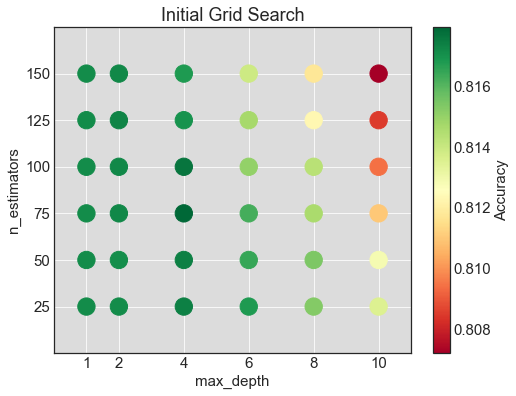

In [37]:
# Lets try to plot it with colors in a 2d parameter space ----------------------------------

# Create figure
fig, ax = plt.subplots(figsize=(8,6))

# Get parameters
x1 = GridSearch_results['param_max_depth']
x2 = GridSearch_results['param_n_estimators']
color = GridSearch_results['mean_test_score']

mini, maxi = np.min(color), np.max(color) #color ranges


# Plot initial random search
ax.scatter(x1, x2, s=300, c = color, cmap='RdYlGn', zorder=2)
ax.set_facecolor('gainsboro')
ax.grid(color='w')
ax.set_xlabel('max_depth', fontsize=15)
ax.set_ylabel('n_estimators', fontsize=15)
ax.set_title('Initial Grid Search', fontsize=18)

ax.set_xlim(0,11)
ax.set_ylim(0,175)

ax.set_xticks([1,2,4,6,8,10])
ax.set_yticks([25,50,75,100,125,150])

ax.tick_params(axis="x", labelsize=15) 
ax.tick_params(axis="y", labelsize=15)




# Shared colorbar
cbar = fig.colorbar(im2, ax=ax)
cbar.set_label('Accuracy', fontsize=15, x=1.7)
cbar.ax.tick_params(labelsize=15);

In [27]:
%%time

# Grid Search 2 - zoomed grid close to best value #

# Specify parameters and distributions to sample from
parameters_GridSearch2 = {'max_depth': [2,3,4,5,6], 
                         'n_estimators': [50,60,70,80,90,100]}

# Chose number of iterations and number of folds
k = 5

GridSearch2 = GridSearchCV(model_temp, 
                           param_grid=parameters_GridSearch2, 
                           cv=k, 
                           return_train_score=True,
                           scoring = 'accuracy')

# Fit the random search instance
GridSearch2.fit(train, train_class);

# Get results
GridSearch2_results = pd.DataFrame(GridSearch2.cv_results_)                 
print("Grid Search: \tBest parameters: ", GridSearch2.best_params_, f", Best scores: {GridSearch2.best_score_:.3f}")

GridSearch2_results.head(3)

Grid Search: 	Best parameters:  {'max_depth': 4, 'n_estimators': 80} , Best scores: 0.818
CPU times: user 6min 20s, sys: 1min 5s, total: 7min 26s
Wall time: 1min 22s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.179290,0.022832,0.003312,0.000569,2,50,"{'max_depth': 2, 'n_estimators': 50}",0.823,0.81425,0.81925,...,0.81710,0.003717,17,0.815937,0.818063,0.816875,0.818688,0.817375,0.817388,0.000950
1,0.219279,0.007222,0.002888,0.000534,2,60,"{'max_depth': 2, 'n_estimators': 60}",0.823,0.81425,0.81925,...,0.81710,0.003717,17,0.815875,0.818125,0.816875,0.818562,0.817375,0.817362,0.000946
2,0.272837,0.023780,0.003717,0.001066,2,70,"{'max_depth': 2, 'n_estimators': 70}",0.823,0.81450,0.81925,...,0.81715,0.003680,15,0.815875,0.818063,0.817000,0.818562,0.817438,0.817388,0.000925


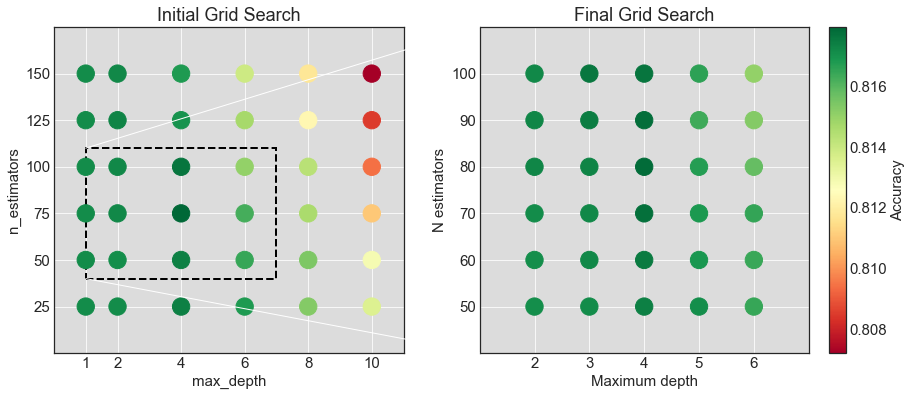

In [30]:
# Lets try to plot it with colors in a 2d parameter space ----------------------------------

# Create figure
fig, ax = plt.subplots(ncols=2, figsize=(15,6), gridspec_kw={'wspace':0.2, 'width_ratios':(1.7,2)})

# Get parameters
x1 = GridSearch_results['param_max_depth']
x2 = GridSearch_results['param_n_estimators']
color = GridSearch_results['mean_test_score']

x1_2 = GridSearch2_results['param_max_depth']
x2_2 = GridSearch2_results['param_n_estimators']
color2 = GridSearch2_results['mean_test_score']

mini, maxi = np.min(np.concatenate((color,color2))), np.max(np.concatenate((color,color2))) #color ranges


# Plot initial random search
ax[0].scatter(x1, x2, s=300, c = color, cmap='RdYlGn', zorder=2)
ax[0].set_facecolor('gainsboro')
ax[0].grid(color='w')
ax[0].set_xlabel('Max depth', fontsize=15)
ax[0].set_ylabel('N estimators', fontsize=15)
ax[0].set_title('Initial Grid Search', fontsize=18)

ax[0].set_xlim(0,11)
ax[0].set_ylim(0,175)

ax[0].set_xticks([1,2,4,6,8,10])
ax[0].set_yticks([25,50,75,100,125,150])

ax[0].tick_params(axis="x", labelsize=15) 
ax[0].tick_params(axis="y", labelsize=15)


# Plot final search
im2 = ax[1].scatter(x1_2, x2_2, s=300, c = color2, cmap='RdYlGn', zorder=2, vmin=mini, vmax=maxi)
ax[1].set_facecolor('gainsboro')
ax[1].grid(color='w')
ax[1].set_xlabel('Max depth', fontsize=15)
ax[1].set_ylabel('N estimators', fontsize=15)
ax[1].set_title('Final Grid Search', fontsize=18)

ax[1].set_xlim(1,7)
ax[1].set_ylim(40,110)

ax[1].set_xticks([2,3,4,5,6])
ax[1].set_yticks([50,60,70,80,90,100])

ax[1].tick_params(axis="x", labelsize=15) 
ax[1].tick_params(axis="y", labelsize=15)


# Shared colorbar
cbar = fig.colorbar(im2, ax=ax[1])
cbar.set_label('Accuracy', fontsize=15, x=1.7)
cbar.ax.tick_params(labelsize=15)


# Mark the zoom in plot ------------------------
xlim2 = (1,7)
ylim2 = (40,110)

# Square (x,y,width,height)
rect = patches.Rectangle((xlim2[0],ylim2[0]), xlim2[1]-xlim2[0], ylim2[1]-ylim2[0], linewidth=2, edgecolor='k', facecolor='none', linestyle='dashed')
ax[0].add_patch(rect)
# Lines
line1 = patches.ConnectionPatch(xyA=(xlim2[0],ylim2[1]), xyB=(xlim2[0],ylim2[1]), coordsA=ax[0].transData, coordsB=ax[1].transData)
fig.add_artist(line1)
line2 = patches.ConnectionPatch(xyA=(xlim2[0],ylim2[0]), xyB=(xlim2[0],ylim2[0]), coordsA=ax[0].transData, coordsB=ax[1].transData)
fig.add_artist(line2)

    
plt.show()

In [38]:
# Set the hyperparameters found
max_depth_GS = GridSearch2.best_params_['max_depth']
n_estimators_GS = GridSearch2.best_params_['n_estimators']
print('We use max depth:', max_depth_GS, 'and n_estimators:', n_estimators_GS)

We use max depth: 4 and n_estimators: 80


## Train algorithm

In [44]:
# Training data
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth_GS, splitter='best'), algorithm="SAMME", n_estimators=n_estimators_GS)
clf = clf.fit(train, train_class)

# Testing our algorithm on the training and testing data
twoclass_output_train = clf.decision_function(train)
twoclass_output_test = clf.decision_function(test)

### Changing the output for confusion matrix

In [45]:
twoclass_output_train_cm = aas.twoclass_output_for_cm(twoclass_output_train)
twoclass_output_test_cm = aas.twoclass_output_for_cm(twoclass_output_test)

In [62]:
reload(aas);

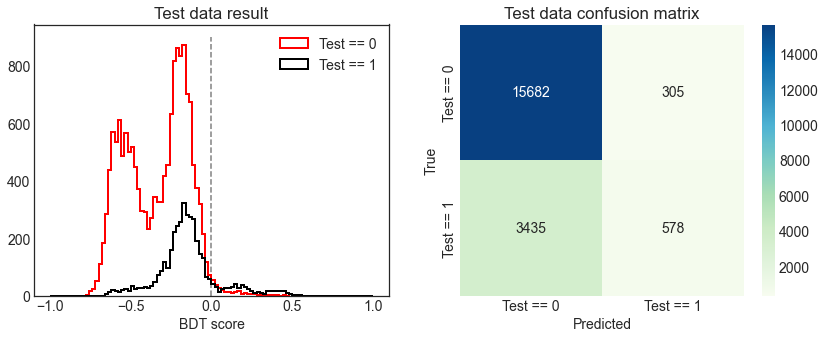

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))
hist0_test, hist1_test, vals_test = aas.clf_result(twoclass_output_test, twoclass_output_test_cm, test_class, 'Test', axes)

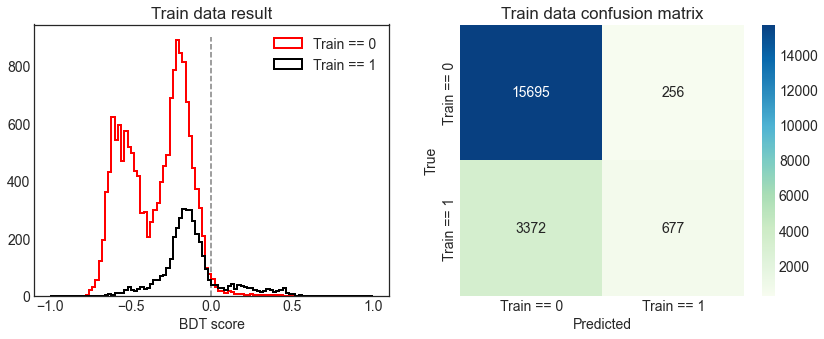

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))
hist0_train, hist1_train, vals_train = aas.clf_result(twoclass_output_train, twoclass_output_train_cm, train_class, 'Train', axes)

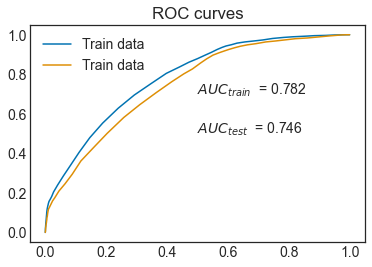

In [56]:
fig, ax = plt.subplots()
aas.clf_roc(hist0_train, hist1_train, hist0_test, hist1_test, ax)

In [65]:
print('Test:')
print('True positive rate =', aas.TPR(vals_test[3], vals_test[2]))
print('False positive rate =', aas.FPR(vals_test[1], vals_test[0]))

print('\nTrain:')
print('True positive rate =', aas.TPR(vals_train[3], vals_train[2]))
print('False positive rate =', aas.FPR(vals_train[1], vals_train[0]))

Test:
True positive rate = 0.14403189633690505
False positive rate = 0.019078000875711515

Train:
True positive rate = 0.16720177821684368
False positive rate = 0.01604915052347815


In [72]:
accuracy_test = accuracy_score(y_true=test_class, y_pred=twoclass_output_test_cm)
accuracy_train = accuracy_score(y_true=train_class, y_pred=twoclass_output_train_cm)

print('Test accuracy:',  accuracy_test)
print('Train accuracy:',  accuracy_train)

Test accuracy: 0.813
Train accuracy: 0.8186


## Feature importance based on mean decrease in impurity

Feature importances are provided by the fitted attribute feature_importances_ and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.

http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

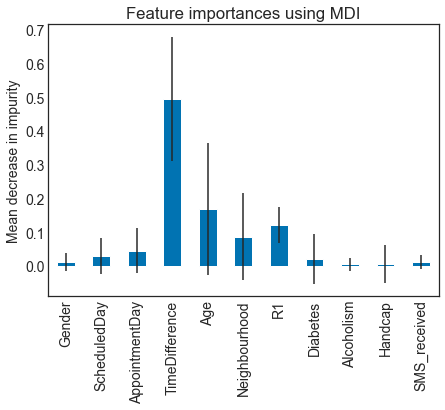

In [49]:
fig, ax = plt.subplots(figsize=(7,5))
aas.feature_importance_mdi(clf, features, ax)

# Feature importance based on MDI and on feature permutation

Permutation feature importance overcomes limitations of the impurity-based feature importance: they do not have a bias toward high-cardinality features and can be computed on a left-out test set.

http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

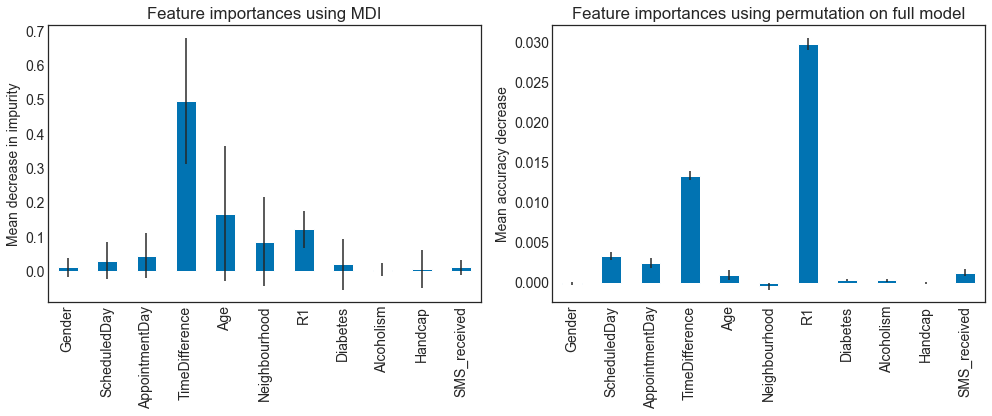

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
aas.feature_importance(clf, features, test, test_class, axes)
fig.tight_layout()

In [13]:
'''
depth = [2,4,6]
n_est = [200, 300, 400]

fig, axes = plt.subplots(3,3, figsize=(12,12), sharex=True, sharey=True)
for idxi, i in enumerate(depth):
    for idxj, j in enumerate(n_est):
        clf_ = AdaBoostClassifier(DecisionTreeClassifier(max_depth=i, splitter='best'), algorithm="SAMME", n_estimators=j)
        plt.figure()
        # TESTING DATA
        clf_ = clf_.fit(train, train_class)
        twoclass_output = clf_.decision_function(test)
        hist0 = ax.hist(twoclass_output[test_class==0], bins=100, range=range)
        hist1 = ax.hist(twoclass_output[test_class==1], bins=100, range=range)
        FPR, TPR, AUC = aas.calc_ROC(hist1, hist0) # first histogram has to be signal
        axes[idxi][idxj].plot(FPR, TPR, label = f'Test data')
        axes[idxi][idxj].text(0.4, 0.7, r'$AUC_{test}$  = %s' %round(AUC,3))
        
        # TRAINING DATA
        twoclass_output_train = clf_.decision_function(train)
        hist0_train = ax.hist(twoclass_output_train[train_class==0], bins=100, range=range)
        hist1_train = ax.hist(twoclass_output_train[train_class==1], bins=100, range=range)
        FPR_train, TPR_train, AUC_train = aas.calc_ROC(hist1_train, hist0_train) # first histogram has to be signal
        axes[idxi][idxj].plot(FPR_train, TPR_train, label = f'Train data')
        axes[idxi][idxj].text(0.4, 0.6, r'$AUC_{train}$ = %s' %round(AUC_train,3))
        axes[idxi][idxj].set_title(f'Max depth = {i} and N estimaters = {j}', fontsize=12)
        axes[idxi][idxj].legend()
        
        axes[idxi][0].set_ylabel('TPR')
        axes[2][idxj].set_xlabel('FPR')
'''

'\ndepth = [2,4,6]\nn_est = [200, 300, 400]\n\nfig, axes = plt.subplots(3,3, figsize=(12,12), sharex=True, sharey=True)\nfor idxi, i in enumerate(depth):\n    for idxj, j in enumerate(n_est):\n        clf_ = AdaBoostClassifier(DecisionTreeClassifier(max_depth=i, splitter=\'best\'), algorithm="SAMME", n_estimators=j)\n        plt.figure()\n        # TESTING DATA\n        clf_ = clf_.fit(train, train_class)\n        twoclass_output = clf_.decision_function(test)\n        hist0 = ax.hist(twoclass_output[test_class==0], bins=100, range=range)\n        hist1 = ax.hist(twoclass_output[test_class==1], bins=100, range=range)\n        FPR, TPR, AUC = aas.calc_ROC(hist1, hist0) # first histogram has to be signal\n        axes[idxi][idxj].plot(FPR, TPR, label = f\'Test data\')\n        axes[idxi][idxj].text(0.4, 0.7, r\'$AUC_{test}$  = %s\' %round(AUC,3))\n        \n        # TRAINING DATA\n        twoclass_output_train = clf_.decision_function(train)\n        hist0_train = ax.hist(twoclass_outpu

In [14]:
# Blind data
blinddata = np.genfromtxt('Data/Exam_2022_Prob4_BlindData.csv', delimiter=',', skip_header=1)[:,1:] 
twoclass_output_blind = clf.decision_function(blinddata)
twoclass_output_blind[twoclass_output_blind>0]=1
twoclass_output_blind[twoclass_output_blind<0]=0

IDs = np.genfromtxt('Data/Exam_2022_Prob4_BlindData.csv', delimiter=',', skip_header=1)[:,0] 
IDs_true = IDs[twoclass_output_blind == 1]
IDs_false = IDs[twoclass_output_blind == 0]

print(f'Blind data \nTotal = %s \n%s == 1: %s \n%s == 0: %s \nSN-ratio = %s' \
          %(len(blinddata), label, len(IDs_true), label, len(IDs_false), round(len(IDs_true)/len(IDs_false), 3)))

Blind data 
Total = 20000 
No show == 1: 1054 
No show == 0: 18946 
SN-ratio = 0.056


In [15]:
#np.savetxt('Wilson.Problem4.RevenueTrue.txt', IDs_true)
#np.savetxt('Wilson.Problem4.RevenueFalse.txt', IDs_false)